# Welcome to The Fellowship of the IE4004!

#### Fall 2023 Semester 

Hello brave coders and prospective members of the IE4004 Fellowship! Your quest, should you choose to accept it, involves solving complex optimization problems set within the mystical realms of Middle-Earth.<br>
<br>
This class, your challenge is titled ___"Feeding the Fellowship"___. As you may remember, in The Lord of the Rings, the Fellowship of the Ring embarks on a perilous journey from Rivendell to Mordor.<br>
<br>
Lord Elrond, ever thoughtful, wishes to ensure the Fellowship is well-provisioned for their journey. He needs to distribute available food among the members of the Fellowship, taking into account the dietary preferences and energy needs of each member. The goal is to ensure the Fellowship is sufficiently fed while optimizing the total weight they have to carry.<br>
<br>
Your task is to assist Elrond in this critical mission. You will use Gurobi to solve this optimization problem and determine the best way to allocate food to each member of the Fellowship. <br>
<br>
__Prepare your Python environments, and may your code run error-free!__<br>
<br>
Good luck to all participants, and remember:<br>
<br>
> _"The journey of a thousand lines of code begins with a single keystroke."_ <br>


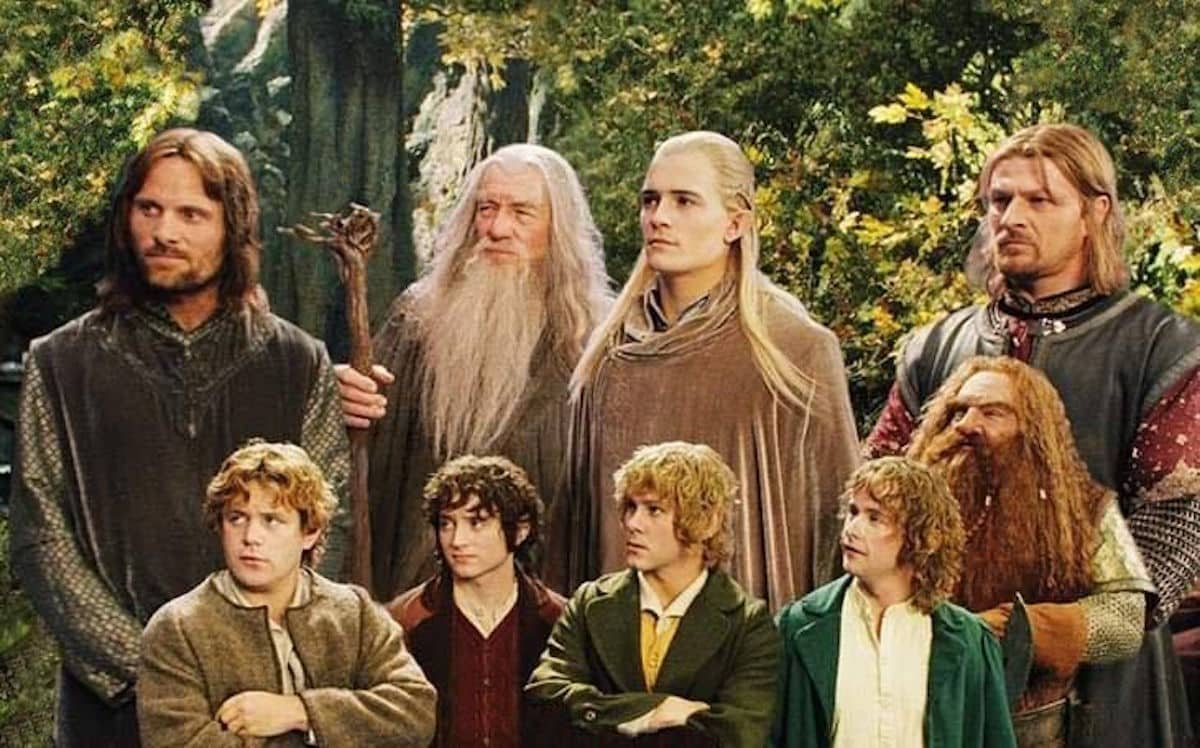

In [14]:
# Import packages we need to use:

import pandas as pd
from gurobipy import Model, GRB

### Data Description

Elrond has five types of food available:
- Lembas
- Cram
- Honeycakes
- Salted Pork
- Mushrooms

and he has a record of how much each member of the Fellowship __likes__ (prefers) each type of food and how much __energy__ (in calories) it provides. <br>

Also, each type of food has a certain __weight__, and there is a __maximum amount of weight__ that the Fellowship can carry. <br>

Let's look at the data Elrond has!


In [15]:
# Initialize data

food_df = pd.DataFrame({
    'food': ['Lembas', 'Cram', 'Honeycakes', 'Salted Pork', 'Mushrooms'],
    'weight': [0.3, 0.5, 0.3, 2, 0.2],  # kg per unit
    'calories': [800, 500, 300, 900, 100],  # per unit
    'available_units': [20, 30, 40, 50, 50]
})

preference_df = pd.DataFrame({
    'member': ['Frodo', 'Sam', 'Merry', 'Pippin', 'Aragorn', 'Boromir', 'Legolas', 'Gimli', 'Gandalf'],
    'Lembas': [9, 9, 8, 8, 8, 7, 7, 6, 9],
    'Cram': [6, 7, 7, 7, 8, 8, 7, 6, 6],
    'Honeycakes': [9, 9, 9, 9, 7, 6, 6, 5, 6],
    'Salted Pork': [6, 7, 7, 7, 9, 9, 8, 8, 7],
    'Mushrooms': [10, 9, 10, 10, 6, 5, 5, 4, 5],
    'capacity': [1, 6, 4, 3, 7, 8, 6, 8, 5] 
})


display(food_df)
display(preference_df)

#max_weight_carried = 50

#print('The fellowship can only carry '+ str(max_weight_carried)+ ' kgs of food in total!')


,food,weight,calories,available_units
0,Lembas,0.3,800,20
1,Cram,0.5,500,30
2,Honeycakes,0.3,300,40
3,Salted Pork,2.0,900,50
4,Mushrooms,0.2,100,50


,member,Lembas,Cram,Honeycakes,Salted Pork,Mushrooms,capacity
0,Frodo,9,6,9,6,10,1
1,Sam,9,7,9,7,9,6
2,Merry,8,7,9,7,10,4
3,Pippin,8,7,9,7,10,3
4,Aragorn,8,8,7,9,6,7
5,Boromir,7,8,6,9,5,8
6,Legolas,7,7,6,8,5,6
7,Gimli,6,6,5,8,4,8
8,Gandalf,9,6,6,7,5,5


__Step 1:__ Start by defining your model!

In [16]:
# Model
m = Model('FeedingFellowship')

__Step 2:__ Define your decision variables

We are looking to find how much of each type of food fellowship members should carry! (e.g. how much Lembas Frodo should carry, how much honeycakes should Legolas carry, ...). So, we our decision variables should be defined considering all these combinations. 

In [17]:
# Decision Variables
Number_of_members = preference_df.index 
Number_of_food = food_df.index

# addVars accepts a list of arguments for various vectors, vtypes generally CONTINOUS and name is generic string
x = m.addVars(Number_of_members, Number_of_food, vtype=GRB.CONTINUOUS, name="allocate")

# Let's see how our variables look
x

{(0, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 3): <gurobi.Var *Awaiting Model Update*>,
 (0, 4): <gurobi.Var *Awaiting Model Update*>,
 (1, 0): <gurobi.Var *Awaiting Model Update*>,
 (1, 1): <gurobi.Var *Awaiting Model Update*>,
 (1, 2): <gurobi.Var *Awaiting Model Update*>,
 (1, 3): <gurobi.Var *Awaiting Model Update*>,
 (1, 4): <gurobi.Var *Awaiting Model Update*>,
 (2, 0): <gurobi.Var *Awaiting Model Update*>,
 (2, 1): <gurobi.Var *Awaiting Model Update*>,
 (2, 2): <gurobi.Var *Awaiting Model Update*>,
 (2, 3): <gurobi.Var *Awaiting Model Update*>,
 (2, 4): <gurobi.Var *Awaiting Model Update*>,
 (3, 0): <gurobi.Var *Awaiting Model Update*>,
 (3, 1): <gurobi.Var *Awaiting Model Update*>,
 (3, 2): <gurobi.Var *Awaiting Model Update*>,
 (3, 3): <gurobi.Var *Awaiting Model Update*>,
 (3, 4): <gurobi.Var *Awaiting Model Update*>,
 (4, 0): <gurobi.Var *Awaiting Model Update*>,
 (4, 1): <gur

__Step 3:__ Define your objective function

Elrond did not specify our objective clearly, and said we should do it the ___best___ way. Hmm... That can mean multiple different things; however, in our case it can only mean certain things because our data only enables us to consider food __preferences__ or __calories__. _(You might be shocked to learn how often this happens in real-life)_

>Let's first try allocating food to fellowship members optimally __based on their food preferences__!

In [18]:
# Objective Function

obj1 = 0
for i in Number_of_members:
    for j in Number_of_food:
        obj1 += x[i, j]*preference_df.loc[i, food_df.loc[j, 'food']]
        
m.setObjective(obj1, GRB.MAXIMIZE)

# Another syntax for the objective function
m.setObjective(sum(x[i,j]*preference_df.loc[i,food_df.loc[j,'food']] for i in Number_of_members for j in Number_of_food), GRB.MAXIMIZE)


__Step 3 (cont'd):__ Define your objective function

>Now let's try allocating food to fellowship members optimally __to maximize calories__!

In [19]:
# Objective Function

obj2 = 0
for i in Number_of_members:
    for j in Number_of_food:
        obj2 += x[i, j]*food_df.loc[j, 'calories']
        
m.setObjective(obj2, GRB.MAXIMIZE)


__Step 4:__ Define your constraints

We have couple constraints in this problem:
- Availabilty of each food item differs (supply is limited)
- Each member of the fellowship can only carry a certain amount of food (there is an upper limit on weight carried)

In [20]:
# Constraint 1: Do not exceed available units of each food 
# (e.g. sum of number of Lembas allocated to each member should be less than the total available Lembas )

for j in Number_of_food:
    m.addConstr(sum(x[i, j] for i in Number_of_members) <= food_df.loc[j, 'available_units'])
    
# Constraint 2: Do not exceed individual carrying capacities
# (e.g. sum of weights associated with each food item Frodo carries should not exceed his capacity. Otherwise, Gollum might take his precious back ;) 
for i in Number_of_members:
    total_weight = sum(x[i, j]*food_df.loc[j, 'weight'] for j in Number_of_food)
    m.addConstr(total_weight <= preference_df.loc[i, 'capacity'])
    

# If we had a collective capacity for the whole fellowship instead of having individual carry limits
# (e.g. sum of weights associated with each food allocated should be less than the max weight fellowship can carry)

#total_weight = sum(x[i, j]*food_df.loc[j, 'weight'] for i in Number_of_members for j in Number_of_food)
#m.addConstr(total_weight <= 50)


__Step 5:__ Solve your optimization model!

In [21]:
# Solve the model
m.optimize()  # yes, it is this easy. no, I'm not joking.


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 14 rows, 45 columns and 90 nonzeros
Model fingerprint: 0xb6762239
Coefficient statistics:
  Matrix range     [2e-01, 2e+00]
  Objective range  [1e+02, 9e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 13 rows, 45 columns, 81 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2800000e+05   3.915092e+01   0.000000e+00      0s
      25    5.0250000e+04   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.02 seconds (0.00 work units)
Optimal objective  5.025000000e+04


__Step 6:__ Let's look at our results! 

In [8]:
solution_df = pd.DataFrame(columns=['Member', 'Food', 'Units'])

if m.status == GRB.OPTIMAL:
    for v in m.getVars():
        if v.x > 0:
            member_idx = int(v.varName.split('[')[1].split(',')[0])
            food_idx = int(v.varName.split('[')[1].split(',')[1].split(']')[0])
            row = {
                'Member': preference_df.loc[member_idx, 'member'],
                'Food': food_df.loc[food_idx, 'food'],
                'Units': v.x
            }
            solution_df = solution_df.append(row, ignore_index=True)

# Display the solution
solution_df

,Member,Food,Units
0,Frodo,Mushrooms,5.000000
1,Sam,Honeycakes,20.000000
2,Merry,Lembas,13.333333
3,Pippin,Cram,6.000000
4,Aragorn,Cram,6.000000
5,Aragorn,Mushrooms,20.000000
6,Boromir,Lembas,6.666667
7,Boromir,Cram,2.000000
8,Boromir,Salted Pork,2.500000
9,Legolas,Honeycakes,20.000000


In [44]:
# Print the solution in text format
if m.status == GRB.OPTIMAL:
    for v in m.getVars():
        if v.x > 0:
            member_idx = int(v.varName.split('[')[1].split(',')[0])
            food_idx = int(v.varName.split('[')[1].split(',')[1].split(']')[0])
            print(f"Allocate {v.x} units of {food_df.loc[food_idx, 'food']} to {preference_df.loc[member_idx, 'member']}")

Allocate 5.0 units of Mushrooms to Frodo
Allocate 13.333333333333334 units of Honeycakes to Sam
Allocate 10.0 units of Mushrooms to Sam
Allocate 20.0 units of Mushrooms to Merry
Allocate 15.0 units of Mushrooms to Pippin
Allocate 23.333333333333336 units of Honeycakes to Aragorn
Allocate 16.0 units of Cram to Boromir
Allocate 10.000000000000002 units of Cram to Legolas
Allocate 3.3333333333333304 units of Honeycakes to Legolas
Allocate 6.000000000000001 units of Lembas to Gimli
Allocate 3.9999999999999982 units of Cram to Gimli
Allocate 5.0 units of Lembas to Gandalf


# Congratulations members of the Fellowship! 

### We are ready for a celebration: https://www.youtube.com/watch?v=DKP16d_WdZM

Author: Yaren Bilge Kaya, PhD <BR>
Date: 07/19/2023